In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import SimpleITK as sitk
from tqdm import tqdm

from src.seg_dataset import SegDatasetCreator
from src.utils.competition_metric import ULS23_evaluator

import collections
import itertools

import numpy as np
import torch
from scipy.ndimage import binary_erosion, label
from scipy.spatial.distance import pdist, squareform

import pandas as pd
from collections import Counter
import random

from tqdm import tqdm

# Enable tqdm for pandas
tqdm.pandas()


In [2]:
!which python

/d/hpc/projects/FRI/jf73497/aimi-project/SegFormer3D-main/venv_segformer/bin/python


In [5]:
segformer_csv_path = "/d/hpc/home/jf73497/projects/aimi-project/SegFormer3D-main/data/uls2023_all_data/uls2023_raw_data/datameta_generator/train.csv"
data = pd.read_csv(segformer_csv_path)

data['training_path'] = data['data_path'] + "/" + data['case_name'] + '_im.pt'
data['label_path'] = data['data_path'] + "/" + data['case_name'] + '_label.pt'
data['spacings_path'] = data['data_path'] + "/" + data['case_name'] + '_label_spacings.pt'
evaluator = ULS23_evaluator()

data.head()

# FOR TESTING
# data = data.head(10)

,data_path,case_name,training_path,label_path,spacings_path
0,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_02044,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...
1,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_01124,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...
2,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_02351,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...
3,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_04320,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...
4,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_02349,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...


In [20]:
def calculate_lesion_sizes(label_path, spacings_path):
    #print(f"Calculating lesion sizes for {label_path} and {spacings_path}")
    label_array = torch.load(label_path, weights_only=False)
    # Spacing should be reversed in order to align the z axis in the image and spacings arrays but w/e  
    voxel_spacing = np.array(torch.load(spacings_path, weights_only=False)[:3])
    #print(f"Voxel spacing: {voxel_spacing}")

    #print(f"Label array shape: {label_array.shape}") 
    label_array = (label_array[1:, ...]).squeeze()
    #print(f"Label array shape after removing first slice: {label_array.shape}") 
    _, _, long_axis_points, short_axis_points = evaluator.long_and_short_axis_diameters(label_array)

    #print(f"Long axis points: {long_axis_points}")
    if long_axis_points is None:
        # No idea why this happens but its only a few cases and i think we can ignore it
        return (0, 0)
    
    p1_long, p2_long = long_axis_points
    p1_short, p2_short = short_axis_points

    vec_long = (p2_long - p1_long) * voxel_spacing
    vec_short = (p2_short - p1_short) * voxel_spacing

    # Compute Euclidean distances (in mm)
    label_long_mm = np.linalg.norm(vec_long)
    label_short_mm = np.linalg.norm(vec_short)
    
    return (label_long_mm, label_short_mm)

In [21]:
os.chdir("/d/hpc/home/jf73497/projects/aimi-project/SegFormer3D-main/experiments/uls_2023/dice_oversampled_experiment/")       

data[['long_axis_mm', 'short_axis_mm']] = data.progress_apply(lambda row: pd.Series(calculate_lesion_sizes(row['label_path'], row['spacings_path'])), axis=1)

100%|██████████| 7208/7208 [20:45<00:00,  5.79it/s] 


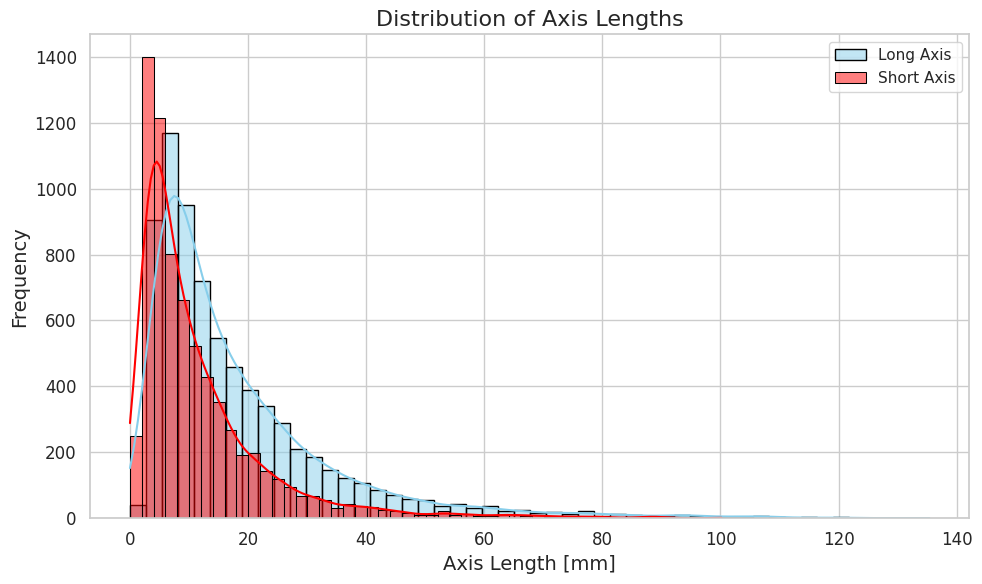

In [22]:
BINS = 50

# Set the Seaborn style
sns.set_theme(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['long_axis_mm'], bins=BINS, kde=True, color='skyblue', edgecolor='black', label='Long Axis')
sns.histplot(data['short_axis_mm'], bins=BINS, kde=True, color='red', edgecolor='black', label='Short Axis')


# Customize the plot
plt.title("Distribution of Axis Lengths", fontsize=16)
plt.xlabel("Axis Length [mm]", fontsize=14)
plt.ylabel("Frequency", fontsize=14) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
long_axis_weigth = 0.8
short_axis_weigth = 0.2

data['combined_size'] = data.progress_apply(lambda row: row['long_axis_mm']*long_axis_weigth + row['short_axis_mm']*short_axis_weigth, axis=1)

data

100%|██████████| 7208/7208 [00:00<00:00, 197884.15it/s]


,data_path,case_name,training_path,label_path,spacings_path,long_axis_mm,short_axis_mm,combined_size
0,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_02044,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,7.827460,3.913730,7.044714
1,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_01124,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,26.774202,22.989069,26.017176
2,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_02351,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,95.867035,68.280127,90.349653
3,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_04320,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,9.496791,5.511311,8.699695
4,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_02349,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,9.178756,6.468544,8.636714
...,...,...,...,...,...,...,...,...
7203,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_06976,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,13.097350,9.225444,12.322969
7204,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_06540,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,7.394197,4.929465,6.901250
7205,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_06891,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,7.093872,9.118398,7.498778
7206,../../../data/uls2023_all_data/ULS2023_Trainin...,MIX_04122,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,../../../data/uls2023_all_data/ULS2023_Trainin...,24.437500,9.005912,21.351182


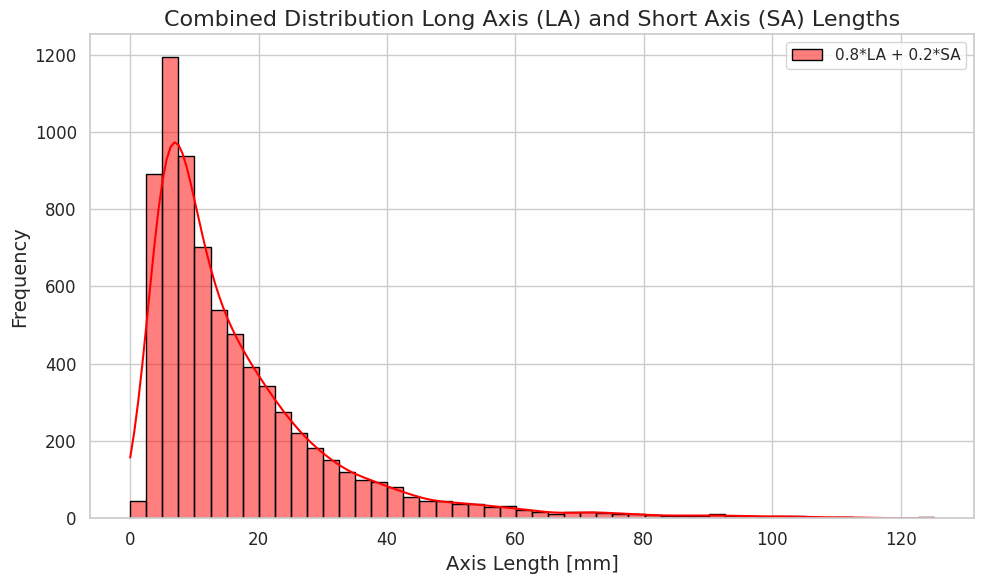

In [24]:
BINS = 50

# Set the Seaborn style
sns.set_theme(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data['combined_size'], bins=BINS, kde=True, color='red', edgecolor='black', label=f'{long_axis_weigth}*LA + {short_axis_weigth}*SA')


# Customize the plot
plt.title("Combined Distribution Long Axis (LA) and Short Axis (SA) Lengths", fontsize=16)
plt.xlabel("Axis Length [mm]", fontsize=14)
plt.ylabel("Frequency", fontsize=14) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.legend()
plt.tight_layout()
plt.show()

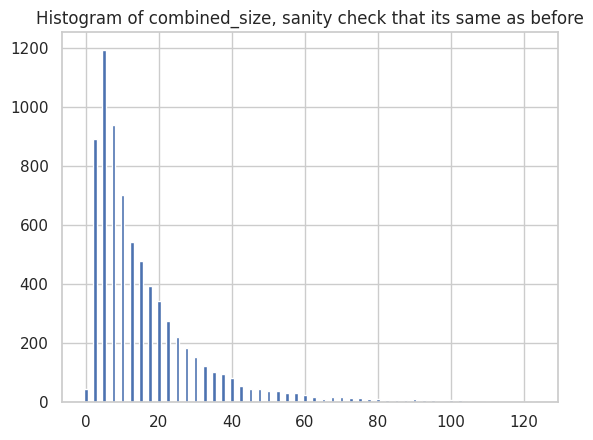

In [25]:
np.random.seed(42)

STRENGTH = 1.2

combined_axis_size = data['combined_size'].values

mean = np.mean(combined_axis_size)
std = np.std(combined_axis_size)

# Bin the data
hist, bin_edges = np.histogram(combined_axis_size, bins=50)
# Sanity check
plt.bar(bin_edges[:-1],hist,width=1)
plt.title("Histogram of combined_size, sanity check that its same as before")
plt.show()

# Assign each value to a bin
bin_indices = np.digitize(combined_axis_size, bin_edges) - 1
bin_counts = Counter(bin_indices)

bin_probabilities = 1 / np.array(list(bin_counts.values()))
bin_probabilities /= np.sum(bin_probabilities)
bin_probabilities = dict(zip(bin_counts.keys(), bin_probabilities))

# Inverse frequency weights (with temperature control)
weights = np.array([bin_probabilities[i] for i in bin_indices])
weights = weights ** STRENGTH
weights = weights / np.sum(weights)

# Sample more from rare bins
oversample_count = len(data) // 2
sampled_indices = np.random.choice(len(data), size=oversample_count, replace=True, p=weights)
# Get the sampled rows
oversampled_rows = data.iloc[sampled_indices]

# Keep only those outside 1 std from the mean
outside_std_mask = (oversampled_rows['combined_size'] < mean - std) | \
                   (oversampled_rows['combined_size'] > mean + std)
filtered_oversampled_rows = oversampled_rows[outside_std_mask]

# Append to the original DataFrame
combined_oversampled_data = pd.concat([data, filtered_oversampled_rows], ignore_index=True)

# Optional: shuffle
combined_oversampled_data = combined_oversampled_data.sample(frac=1).reset_index(drop=True)


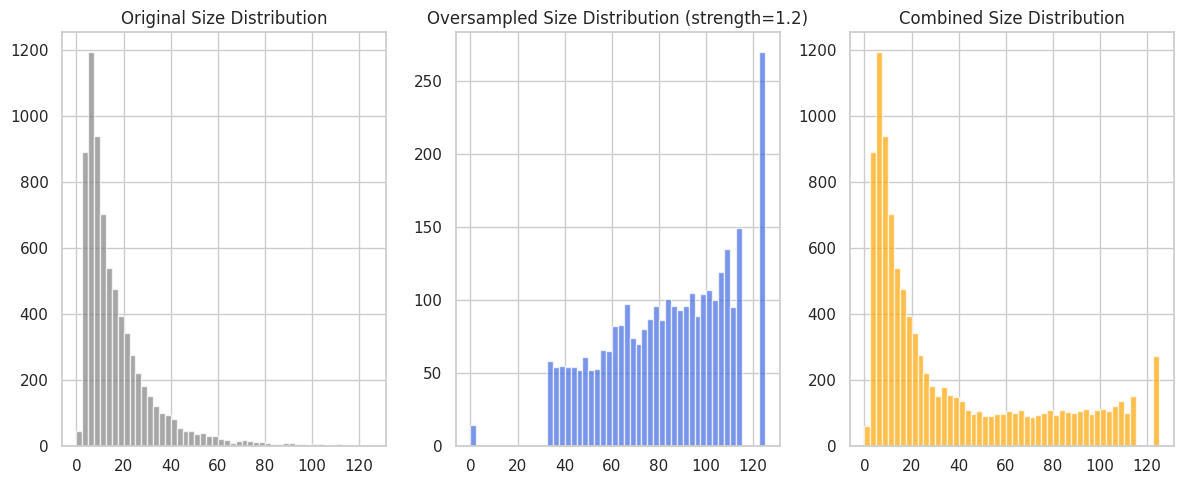

In [26]:
# Plot original and oversampled distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.hist(combined_axis_size, bins=BINS, color='gray', alpha=0.7)
plt.title("Original Size Distribution")

plt.subplot(1, 3, 2)
plt.hist(filtered_oversampled_rows['combined_size'].values, bins=BINS, color='royalblue', alpha=0.7)
plt.title(f"Oversampled Size Distribution (strength={STRENGTH})")

plt.subplot(1, 3, 3)
plt.hist(combined_oversampled_data['combined_size'].values, bins=BINS, color='orange', alpha=0.7)
plt.title("Combined Size Distribution")

plt.tight_layout()
plt.show()

In [28]:
# Plot original and oversampled distributions
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 3, 1)
# plt.hist(combined_axis_size, bins=BINS, color='gray', alpha=0.7)
sns.histplot(combined_axis_size, bins=BINS, kde=True, color='#CB0404', edgecolor='black')
plt.ylim([0, 850])
plt.title("Original Lesion Size Distribution", fontsize=18)
plt.xlabel("Size Metric [mm]", fontsize=14)
plt.ylabel("Frequency", fontsize=14) 
plt.tight_layout()
plt.savefig('./orgi_size.pdf')
plt.clf()
# plt.subplot(1, 3, 2)
# plt.hist(filtered_oversampled_rows['combined_size'].values, bins=BINS, color='royalblue', alpha=0.7)
sns.histplot(filtered_oversampled_rows['combined_size'].values, bins=BINS, kde=True, color='#F4631E', edgecolor='black', )
plt.title(f"Oversampled Lesion Size Distribution (strength={STRENGTH})", fontsize=18)
plt.xlabel("Size Metric [mm]", fontsize=14)
plt.ylabel("Frequency", fontsize=14) 
plt.ylim([0, 850])
plt.tight_layout()
plt.savefig('./sample_size.pdf')
plt.clf()
# plt.subplot(1, 3, 3)
# plt.hist(combined_oversampled_data['combined_size'].values, bins=BINS, color='orange', alpha=0.7)
sns.histplot(combined_oversampled_data['combined_size'].values, bins=BINS, kde=True, color='#309898', edgecolor='black')
plt.title("Combined Lesion Size Distribution", fontsize=18)
plt.xlabel("Size Metric [mm]", fontsize=14)
plt.ylabel("Frequency", fontsize=14) 
plt.ylim([0, 850])
plt.tight_layout()
plt.savefig('./combined_size.pdf')
plt.clf()

<Figure size 640x480 with 0 Axes>

In [30]:
print(f"Number of oversampled data points: {len(filtered_oversampled_rows)}, which is {len(filtered_oversampled_rows)/len(data)*100}% of the original data!")

print(os.getcwd())

combined_oversampled_data.head()


combined_oversampled_data[['data_path', 'case_name']].to_csv('./train_all_data_oversampled.csv', index=False)

Number of oversampled data points: 3052, which is 42.34184239733629% of the original data!
/d/hpc/projects/FRI/jf73497/aimi-project/SegFormer3D-main/experiments/uls_2023/dice_oversampled_experiment
